## TOC:
* [Setup](#first-bullet)
* [Affine/Non-affine transformations](#second-bullet)
* [Linear vs Non-linear image operations](#third-bullet)
* [Interpolation](#fourth-bullet)
* [Types of noise. Filters.](#fifth-bullet)
* [TLDR](#last-bullet)

## Setup <a class="anchor" id="first-bullet"></a>

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def read_img_rgb(img_name):
    img_rgb = cv2.cvtColor(cv2.imread(f'../L1/{img_name}'), cv2.COLOR_BGR2RGB)
    return img_rgb

def read_img_grayscale(img_name):
    img_g = cv2.cvtColor(cv2.imread(f'../L1/{img_name}'), cv2.COLOR_BGR2GRAY)
    return img_g

In [4]:
img1 = read_img_rgb('city_1.webp')

## Affine vs Non-affine transformations <a class="anchor" id="second-bullet"></a>

### Perspective and Affine Transformations (Homographies)

**Affine Transformations** and **Perspective Transformations** (also known as **Homographies**) are types of geometric transformations applied to images, points, or shapes to change their positions, orientation, or shape in space. Here’s a breakdown of both concepts:

#### 1. Affine Transformation
An affine transformation is a linear mapping method that preserves points, straight lines, and planes. Affine transformations include translations, rotations, scaling, shearing, and combinations of these.

- **Properties of affine transformations:**
  - Straight lines remain straight.
  - Parallel lines remain parallel.
  - Ratios of distances along parallel lines are preserved.

- **Affine transformation matrix:**
  It can be represented by a 2x3 matrix as:

  $$
  \begin{pmatrix}
  x' \\
  y'
  \end{pmatrix}
  =
  \begin{pmatrix}
  a & b & tx \\
  c & d & ty
  \end{pmatrix}
  \begin{pmatrix}
  x \\
  y \\
  1
  \end{pmatrix}
  $$

  Where:
  - $a, b, c, d$ represent scaling, rotation, and shearing components.
  - $tx, ty$ represent the translation (shifting) components.

#### 2. Perspective Transformation (Homography)
A perspective transformation, or homography, is a more general transformation that can project points from one plane onto another. It can change not only the orientation and position of objects but also their apparent shape, which makes it useful for 3D to 2D projections (like looking at a rectangular object at an angle and seeing it as a trapezoid).

- **Properties of perspective transformations:**
  - Straight lines remain straight.
  - Parallel lines can become non-parallel (and vice versa).
  - Angles and distances are not necessarily preserved.
  - It allows for a more realistic depiction of how objects appear to change shape and size as they move in 3D space.

- **Perspective transformation matrix:**
  It’s represented by a 3x3 matrix as:

  $$
  \begin{pmatrix}
  x' \\
  y' \\
  w'
  \end{pmatrix}
  =
  \begin{pmatrix}
  a & b & c \\
  d & e & f \\
  g & h & 1
  \end{pmatrix}
  \begin{pmatrix}
  x \\
  y \\
  1
  \end{pmatrix}
  $$

  Where:
  - The additional terms involving $g$ and $h$ account for the perspective distortion.
  - The resulting coordinates are obtained by dividing $x'$ and $y'$ by $w'$ to return to homogeneous coordinates (used in computer vision).

#### Key Differences:
- **Affine transformations** only allow for linear transformations where parallelism is preserved, making it less flexible than perspective transformations.
- **Perspective transformations** introduce non-linear distortions, allowing for transformations like tilting or projecting 3D objects onto a 2D plane, where depth effects are visible.

#### Applications
- **Affine transformations** are often used in computer graphics, robotics, and image registration where object relationships like angles and parallel lines need to be preserved.
- **Perspective transformations (homographies)** are commonly used in computer vision (e.g., for camera calibration, image stitching, and object recognition) where 3D objects are mapped to 2D images.


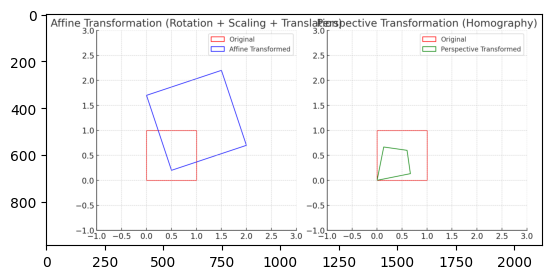

In [238]:
plt.imshow(cv2.imread('output.png'))

In [239]:
image = read_img_rgb('city_1.webp')
rows, cols, ch = image.shape

In [240]:
# Affine Transformation (Translation + Rotation)
pts1 = np.float32([
    [50, 50],
    [200, 50],
    [50, 200]
])
pts2 = np.float32([
    [10, 100], 
    [200, 50], 
    [100, 250]
])

affine_matrix = cv2.getAffineTransform(pts1, pts2)
affine_image = cv2.warpAffine(image, affine_matrix, (cols, rows))

# Perspective Transformation (Non-Affine)
pts1 = np.float32([
    [50, 50], 
    [200, 50], 
    [50, 200], [200, 200]
])
pts2 = np.float32([
    [10, 100], 
    [180, 50], 
    [100, 250], 
    [280, 220]
])

perspective_matrix = cv2.getPerspectiveTransform(pts1, pts2)
perspective_image = cv2.warpPerspective(image, perspective_matrix, (cols, rows))

# Homography
homography_matrix, _ = cv2.findHomography(pts1, pts2)
homography_image = cv2.warpPerspective(image, homography_matrix, (cols, rows))

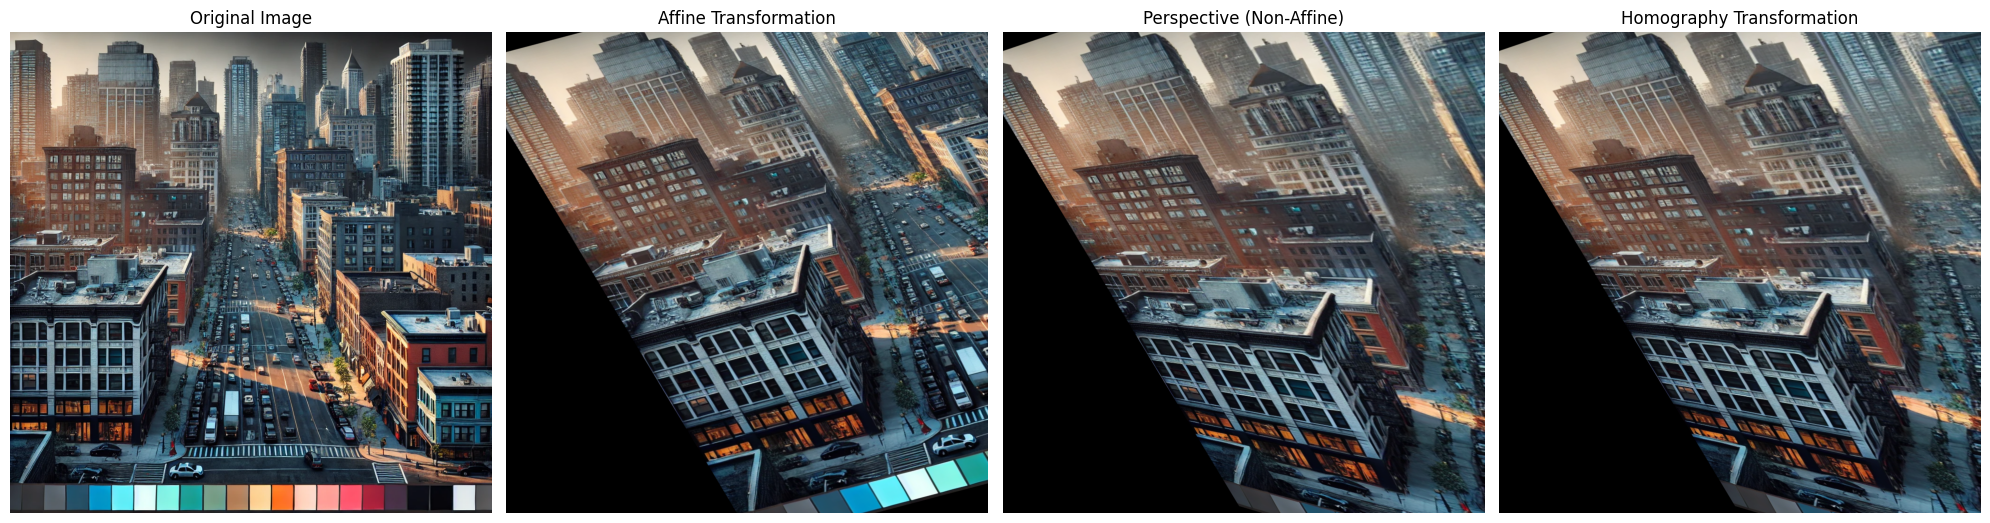

In [241]:

fig, axs = plt.subplots(1, 4, figsize=(20, 10))

# Original Image
axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[0].axis('off')

# Affine Transformed Image
axs[1].imshow(affine_image)
axs[1].set_title('Affine Transformation')
axs[1].axis('off')

# Perspective Transformation (Non-Affine)
axs[2].imshow(perspective_image)
axs[2].set_title('Perspective (Non-Affine)')
axs[2].axis('off')

# Homography Transformed Image
axs[3].imshow(homography_image)
axs[3].set_title('Homography Transformation')
axs[3].axis('off')

plt.tight_layout()
plt.show()

# Examples for using Homography for features matching (features found in object imaged matched with the ones from scene image)

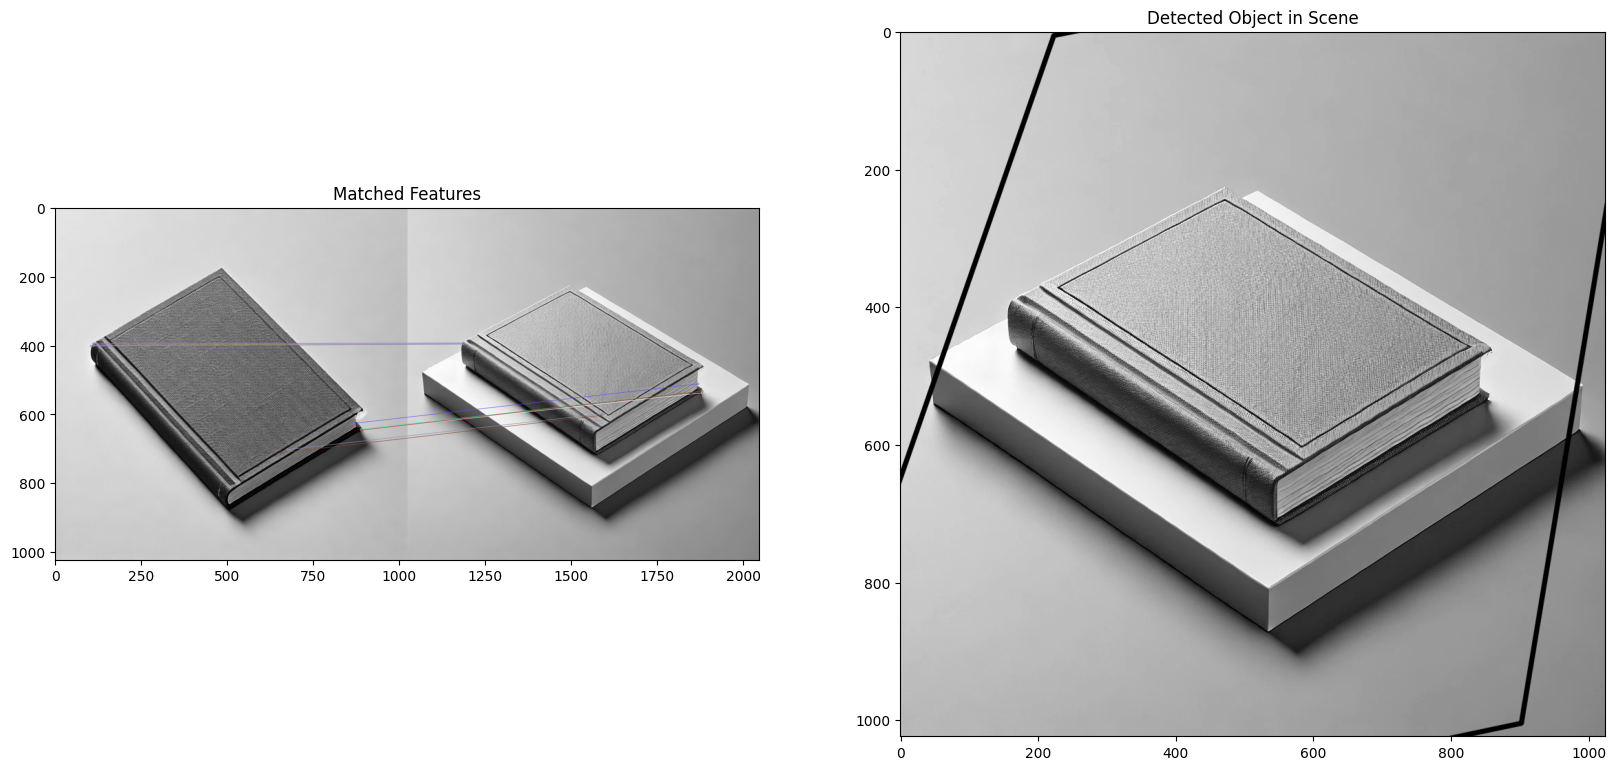

In [10]:
# Load two images: one of the object (query image) and one where the object is to be found (scene image)
img1 = cv2.imread('obj3.jpg', cv2.IMREAD_GRAYSCALE)  # Image of the object (query)
img2 = cv2.imread('scene3.jpg', cv2.IMREAD_GRAYSCALE)   # Image of the scene (where we need to find the object)

# Initialize the ORB detector algorithm
orb = cv2.ORB_create()

# Detect the keypoints and descriptors using ORB in both images
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# Create a Brute Force Matcher object with Hamming distance since we are using ORB
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match the descriptors
matches = bf.match(des1, des2)

# Sort the matches based on distance (lower distance is better)
matches = sorted(matches, key=lambda x: x.distance)

# Draw the top 10 matches between the two images
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Check if there are enough matches to proceed with finding the homography
if len(matches) >= 10:
    # Extract the matching points from both images
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Compute the homography matrix using RANSAC algorithm
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Get the dimensions of the query image
    h, w = img1.shape

    # Define the corners of the object image (rectangle in the object image)
    pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)

    # Map the corners onto the scene image using the homography matrix
    dst = cv2.perspectiveTransform(pts, M)

    # Draw the found object in the scene image (polylines for the object)
    img2 = cv2.polylines(img2, [np.int32(dst)], True, (0, 255, 0), 6, cv2.LINE_AA)

    # Plotting with matplotlib instead of cv2.imshow
    plt.figure(figsize=(20, 10))

    # Display matches
    plt.subplot(1, 2, 1)
    plt.imshow(img_matches)
    plt.title('Matched Features')

    # Display the detected object in the scene
    plt.subplot(1, 2, 2)
    plt.imshow(img2, cmap='gray')
    plt.title('Detected Object in Scene')

    plt.show()

else:
    print("Not enough matches found - {}/{}".format(len(matches), 10))

## Linear vs. Non-Linear Image Operations <a class="anchor" id="third-bullet"></a>

In image processing, operations can be classified into **linear** and **non-linear** based on how the output is affected by the input values. Here's a breakdown of each:

---

### 1. Linear Image Operations

Linear operations are those where the output is a linear combination of the input pixels. These operations are consistent, and their results are directly proportional to the input. 

- **Mathematically**: If an operation $ T $ is linear, it satisfies the properties of additivity and homogeneity:
  - **Additivity**: $ T(a + b) = T(a) + T(b) $
  - **Homogeneity**: $ T(c \cdot a) = c \cdot T(a) $ for any constant $ c $

#### Common Examples of Linear Image Operations:
- **Convolution**: A linear operation where a filter (or kernel) is applied over the image to produce the output. It’s used for blurring, sharpening, and edge detection. In convolution, each output pixel is a weighted sum of the input pixels in its neighborhood.
- **Linear Filtering**:
  - **Gaussian Blur**: Smoothing the image using a Gaussian function
  - **Mean Filter**: Averaging the pixel values in a neighborhood to reduce noise.
- **Brightness Adjustment**: Adding a constant value to all pixels.
- **Contrast Scaling**: Multiplying pixel values by a constant factor.

#### Characteristics of Linear Operations:
- Preserve linear relationships.
- Easy to compute and often used for basic image processing tasks.
- Good at removing Gaussian noise but can blur edges.

---

### 2. Non-Linear Image Operations

Non-linear operations do not satisfy the additivity and homogeneity properties. The output is not a simple linear combination of input pixels; instead, the relationship between the input and output can be more complex.

- **Mathematically**: For a non-linear operation $ T $, the following may not hold:
  - $ T(a + b) \neq T(a) + T(b) $
  - $ T(c \cdot a) \neq c \cdot T(a) $

#### Common Examples of Non-Linear Image Operations:
- **Median Filtering**: A non-linear filter that replaces each pixel's value with the median of the surrounding neighborhood. It is highly effective for removing **salt-and-pepper noise** while preserving edges.
- **Morphological Operations** (e.g., **erosion** and **dilation**)
- **Histogram Equalization**
- **Thresholding**

#### Characteristics of Non-Linear Operations:
- Better at preserving edges and fine details compared to linear operations.
- Can effectively handle non-Gaussian noise.
- More computationally complex.
- Useful for tasks like noise removal, edge detection, and morphological image analysis.

---

### Key Differences:
- **Linear Operations**: Involve direct proportional relationships; they are simpler and often faster but can blur important details like edges.
- **Non-Linear Operations**: Involve more complex relationships and are often better at preserving edges and removing noise, but they are computationally more intensive.

### Application:
- **Linear** operations are commonly used for tasks where preserving global relationships and simplicity is needed (e.g., smoothing and basic filtering).
- **Non-Linear** operations are used when fine detail preservation is crucial (e.g., denoising or image segmentation).


In [5]:
img_g = read_img_grayscale('geometric_shapes.webp')

In [7]:
img_g.shape

(1024, 1024)

In [243]:
# Sobel filter (for edge detection; X direction )
sobel_kernel = np.array([[-1, 0, 1],
                         [-2, 0, 2],
                         [-1, 0, 1]])

In [244]:
# Convolution
convolved_image = cv2.filter2D(img_g, -1, sobel_kernel)

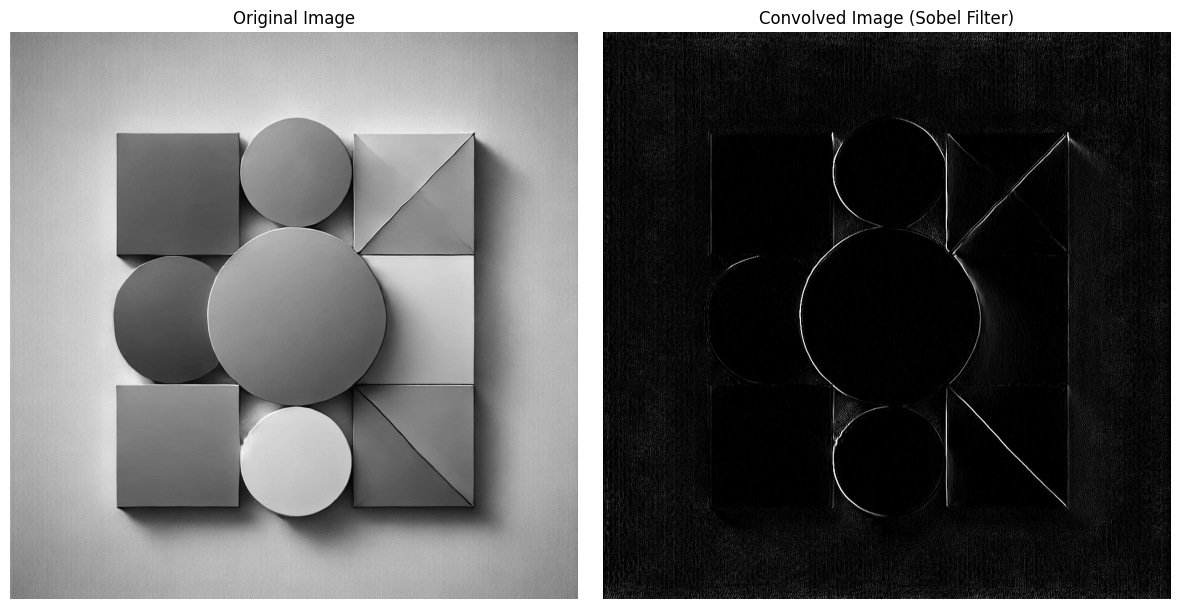

In [245]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Original Image
axs[0].imshow(img_g, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

# Convolved Image (Edge Detection)
axs[1].imshow(convolved_image, cmap='gray')
axs[1].set_title('Convolved Image (Sobel Filter)')
axs[1].axis('off')

plt.tight_layout()
plt.show()

## Image Interpolation <a class="anchor" id="fourth-bullet"></a>

**Image interpolation** is the process used to estimate pixel values (when transforming an image).
---

### Why is Interpolation Needed?

When we perform transformations like:

- **Resizing (scaling)**: Enlarging or shrinking an image.
- **Rotating**: Turning the image by a certain angle.
- **Warping**: Applying a non-uniform transformation to the image.

We often need to calculate pixel values at non-integer positions that don't directly map to the original pixel grid. Interpolation fills these gaps by estimating the values from nearby pixels.

---

### Types of Image Interpolation

#### 1. Nearest Neighbor Interpolation

- **Description**: The simplest form of interpolation. The value of the nearest pixel is assigned to the new pixel.
- **Formula**: The pixel value at location $ (x', y') $ is set to the value of the pixel at the nearest integer coordinates:
  
  $$
  I(x', y') = I\left( \text{round}(x), \text{round}(y) \right)
  $$

- **Advantages**: Fast and easy to compute.
- **Disadvantages**: Can result in a blocky or jagged appearance, especially when enlarging an image.

#### 2. Bilinear Interpolation

- **Description**: Uses the four nearest pixel values (in a 2x2 grid) to compute the new pixel value using a weighted average.
- **Formula**: The pixel value at $ (x', y') $ is computed as a weighted sum of the four surrounding pixels:
  
  $$
  I(x', y') = \sum_{i=1}^{2} \sum_{j=1}^{2} w_{ij} \cdot I(x_i, y_j)
  $$

- **Advantages**: Produces smoother images than nearest neighbor interpolation.
- **Disadvantages**: Can introduce some blurriness.

#### 3. Bicubic Interpolation

- **Description**: Uses the sixteen nearest pixel values (in a 4x4 grid) to compute the new pixel value. It applies cubic interpolation, which takes into account the intensity gradients of neighboring pixels.
- **Formula**: Bicubic interpolation uses cubic polynomials to compute pixel values. The general form is:

  $$
  I(x', y') = \sum_{i=1}^{4} \sum_{j=1}^{4} w_{ij} \cdot I(x_i, y_j)
  $$

- **Advantages**: Produces much smoother and sharper images than bilinear interpolation.
- **Disadvantages**: More computationally expensive.

#### 4. Lanczos Interpolation

- **Description**: Uses a sinc-based function to compute the pixel value over a larger neighborhood. This method is known for preserving image details and sharp edges.
- **Formula**: Lanczos interpolation uses the sinc function, which is defined as:

  $$
  \text{sinc}(x) = \frac{\sin(\pi x)}{\pi x}
  $$

  The pixel value is computed as a weighted sum of nearby pixels using the sinc function.

- **Advantages**: High-quality results, especially when downsampling an image.
- **Disadvantages**: Computationally expensive and can introduce artifacts like ringing.

---

### Applications of Interpolation

1. **Resizing**: Enlarging or shrinking images, where interpolation is used to determine the new pixel values.
2. **Rotation**: When an image is rotated, pixel values at new coordinates need to be interpolated.
3. **Warping and Distortion Correction**: Used when an image is mapped onto a new coordinate system, such as in camera calibration or perspective correction.

---

### Summary of Interpolation Methods

| **Method**          | **Computation**       | **Quality**              | **Speed**               | **Use Case**                  |
|---------------------|-----------------------|--------------------------|-------------------------|-------------------------------|
| Nearest Neighbor     | Fast                  | Low (blocky appearance)   | Fast                    | Simple resizing, low quality   |
| Bilinear            | Moderate               | Smooth, slightly blurry   | Moderate                | General-purpose resizing       |
| Bicubic             | Higher                 | Very smooth, sharp        | Slower                  | High-quality image resizing    |
| Lanczos             | Complex                | Very sharp, preserves details | Slow                  | High-quality downsampling      |


In [246]:
image2 = np.zeros((100, 100, 3), dtype=np.uint8)
image2[30:70, 30:70] = [0, 128, 128]  # Teal square in the center

pass

In [247]:
# Define rotation matrix
angle = 30
center = (image2.shape[1]//2, image2.shape[0]//2)  # Rotate around the center
rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

In [248]:
w, h = image2.shape[0], image2.shape[1]

# 1. Nearest Neighbor Interpolation
rotated_nearest = cv2.warpAffine(image2, rotation_matrix, (w, h), flags=cv2.INTER_NEAREST)

# 2. Bilinear Interpolation
rotated_bilinear = cv2.warpAffine(image2, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR)

# 3. Bicubic Interpolation
rotated_bicubic = cv2.warpAffine(image2, rotation_matrix, (w, h), flags=cv2.INTER_CUBIC)

# 4. Lanczos Interpolation
rotated_lanczos = cv2.warpAffine(image2, rotation_matrix, (w, h), flags=cv2.INTER_LANCZOS4)

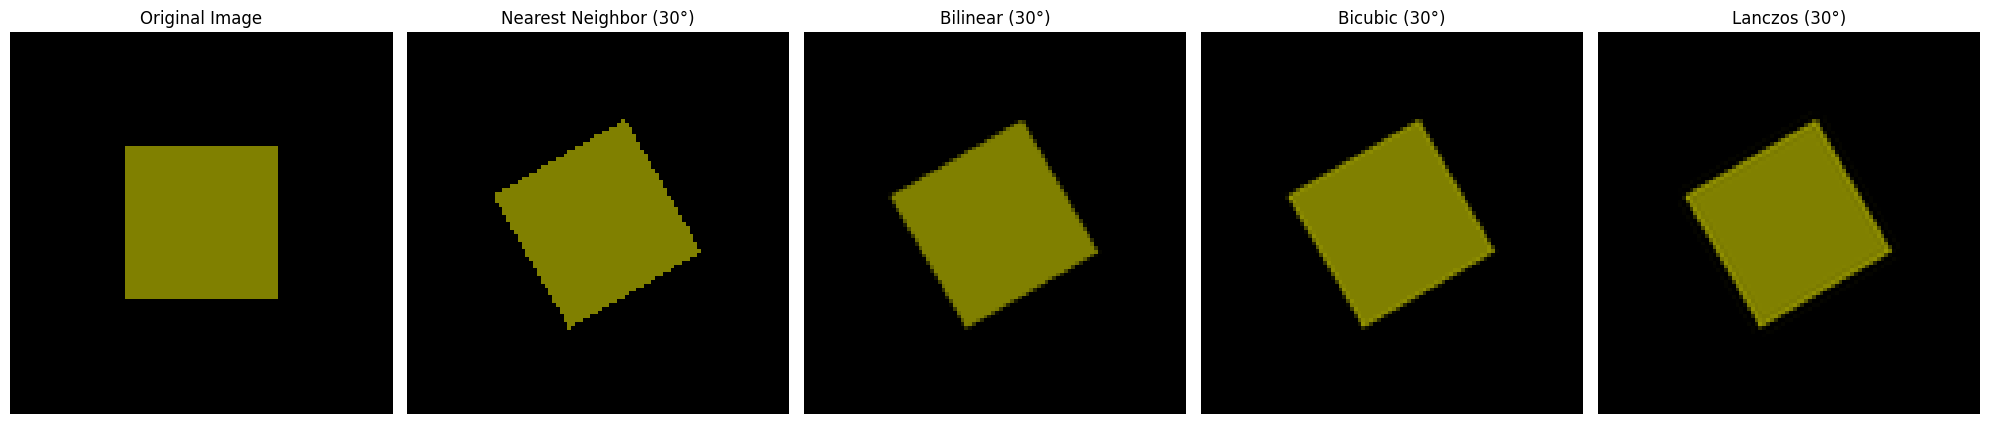

In [249]:
fig, axs = plt.subplots(1, 5, figsize=(20, 10))

# Original Image
axs[0].imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original Image')
axs[0].axis('off')

# Nearest Neighbor
axs[1].imshow(cv2.cvtColor(rotated_nearest, cv2.COLOR_BGR2RGB))
axs[1].set_title('Nearest Neighbor (30°)')
axs[1].axis('off')

# Bilinear
axs[2].imshow(cv2.cvtColor(rotated_bilinear, cv2.COLOR_BGR2RGB))
axs[2].set_title('Bilinear (30°)')
axs[2].axis('off')

# Bicubic
axs[3].imshow(cv2.cvtColor(rotated_bicubic, cv2.COLOR_BGR2RGB))
axs[3].set_title('Bicubic (30°)')
axs[3].axis('off')

# Lanczos
axs[4].imshow(cv2.cvtColor(rotated_lanczos, cv2.COLOR_BGR2RGB))
axs[4].set_title('Lanczos (30°)')
axs[4].axis('off')

plt.tight_layout()
plt.show()

## Types of noise. Filters. <a class="anchor" id="fifth-bullet"></a>

**Image noise** refers to random variations in pixel values that can degrade image quality. Different types of noise occur due to various factors like sensor errors, transmission problems, or environmental conditions.

1. **Gaussian Noise (Additive Noise)**:
   - **Description**: The most common type of noise, where pixel values are randomly altered based on a Gaussian distribution.
   - **Appearance**: Looks like random speckles throughout the image.
   - **Cause**: Low light conditions or electronic sensor noise.
   
2. **Salt-and-Pepper Noise (Impulse Noise)**:
   - **Description**: Pixels are randomly set to either maximum (white) or minimum (black) intensity values.
   - **Appearance**: White and black dots scattered throughout the image.
   - **Cause**: Transmission errors, faulty memory locations.

3. **Poisson Noise (Shot Noise)**:
   - **Description**: Noise due to the statistical nature of light; more noticeable in images captured under low light conditions.
   - **Appearance**: Grainy texture, especially in darker regions.
   - **Cause**: Photon detection errors in image sensors, particularly in low light.

4. **Speckle Noise**:
   - **Description**: Noise commonly seen in medical and radar imaging, characterized by granular noise.
   - **Appearance**: Grainy and dense noise, like fine dust particles.
   - **Cause**: Multiplicative noise in coherent imaging systems like ultrasound, SAR (synthetic aperture radar).

---

### Filters for Removing Noise

**Filters** are image processing techniques used to reduce or remove noise from images while preserving important details like edges.

1. **Mean Filter (Averaging Filter)**:
   - **Description**: Each pixel is replaced by the average of its neighboring pixel values.
   - **Effect**: Reduces noise but can blur edges.
   - **Best for**: Gaussian noise.

2. **Median Filter**:
   - **Description**: Each pixel is replaced by the median value of the surrounding pixels.
   - **Effect**: Effectively removes salt-and-pepper noise without blurring edges.
   - **Best for**: Salt-and-pepper noise.

3. **Gaussian Filter**:
   - **Description**: A linear filter that uses a Gaussian function to smooth the image.
   - **Effect**: Blurs the image to reduce Gaussian noise while preserving edges better than a simple mean filter.
   - **Best for**: Gaussian noise.

4. **Bilateral Filter**:
   - **Description**: A non-linear filter that smooths the image while preserving edges by considering both the spatial distance and intensity difference between pixels.
   - **Effect**: Reduces noise without losing sharp edges.
   - **Best for**: Images where edge preservation is crucial.

5. **Wiener Filter**:
   - **Description**: A filter that minimizes the mean square error between the estimated and actual images by taking into account the noise statistics.
   - **Effect**: Good at reducing various types of noise.
   - **Best for**: Gaussian and Poisson noise.

6. **Non-Local Means Filter**:
   - **Description**: A more advanced filter that replaces each pixel value by the weighted average of similar patches across the image.
   - **Effect**: Reduces noise while preserving textures and fine details.
   - **Best for**: Various types of noise, particularly effective on Gaussian noise.

---

### Summary:
- **Noise types** include Gaussian, salt-and-pepper, Poisson, and speckle noise, each with different causes and appearances.
- **Filters** like the mean, median, Gaussian, bilateral, and Wiener filters are used to reduce noise, each having its strengths and ideal use cases depending on the noise type.


In [250]:
# Gaussian Noise
def add_gaussian_noise(image, mean=0, var=0.01):
    sigma = var ** 0.5
    noisy_image = image + np.random.normal(mean, sigma, image.shape) * 255
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    return noisy_image

# Salt-and-Pepper Noise
def add_salt_and_pepper_noise(image, amount=0.05):
    noisy_image = np.copy(image)
    salt = np.ceil(amount * image.size * 0.5)
    pepper = np.ceil(amount * image.size * 0.5)

    # Add Salt (white pixels)
    coords = [np.random.randint(0, i - 1, int(salt)) for i in image.shape]
    noisy_image[coords[0], coords[1]] = 255

    # Add Pepper (black pixels)
    coords = [np.random.randint(0, i - 1, int(pepper)) for i in image.shape]
    noisy_image[coords[0], coords[1]] = 0
    return noisy_image

# Poisson Noise
def add_poisson_noise(image):
    noisy_image = np.random.poisson(image / 255.0 * 10) / 10 * 255
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    return noisy_image

# Speckle Noise
def add_speckle_noise(image):
    noise = np.random.randn(*image.shape)
    noisy_image = image + image * noise
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    return noisy_image

In [251]:
image = read_img_grayscale('bowls_1.webp')

In [252]:
# Generate noisy images
gaussian_noisy = add_gaussian_noise(image)
salt_pepper_noisy = add_salt_and_pepper_noise(image)
poisson_noisy = add_poisson_noise(image)
speckle_noisy = add_speckle_noise(image)


In [253]:
# Apply filters to reduce noise

# Gaussian Noise: Reduced using a Gaussian filter
# Salt & Pepper Noise: Reduced using a Median filter
# Poisson Noise: Reduced using a Mean filter
# Speckle Noise: Reduced using a Bilateral filter

mean_filtered = cv2.blur(gaussian_noisy, (3, 3))

median_filtered = cv2.medianBlur(salt_pepper_noisy, 3)

gaussian_filtered = cv2.GaussianBlur(gaussian_noisy, (3, 3), 0)

bilateral_filtered = cv2.bilateralFilter(speckle_noisy, 5, 75, 75)

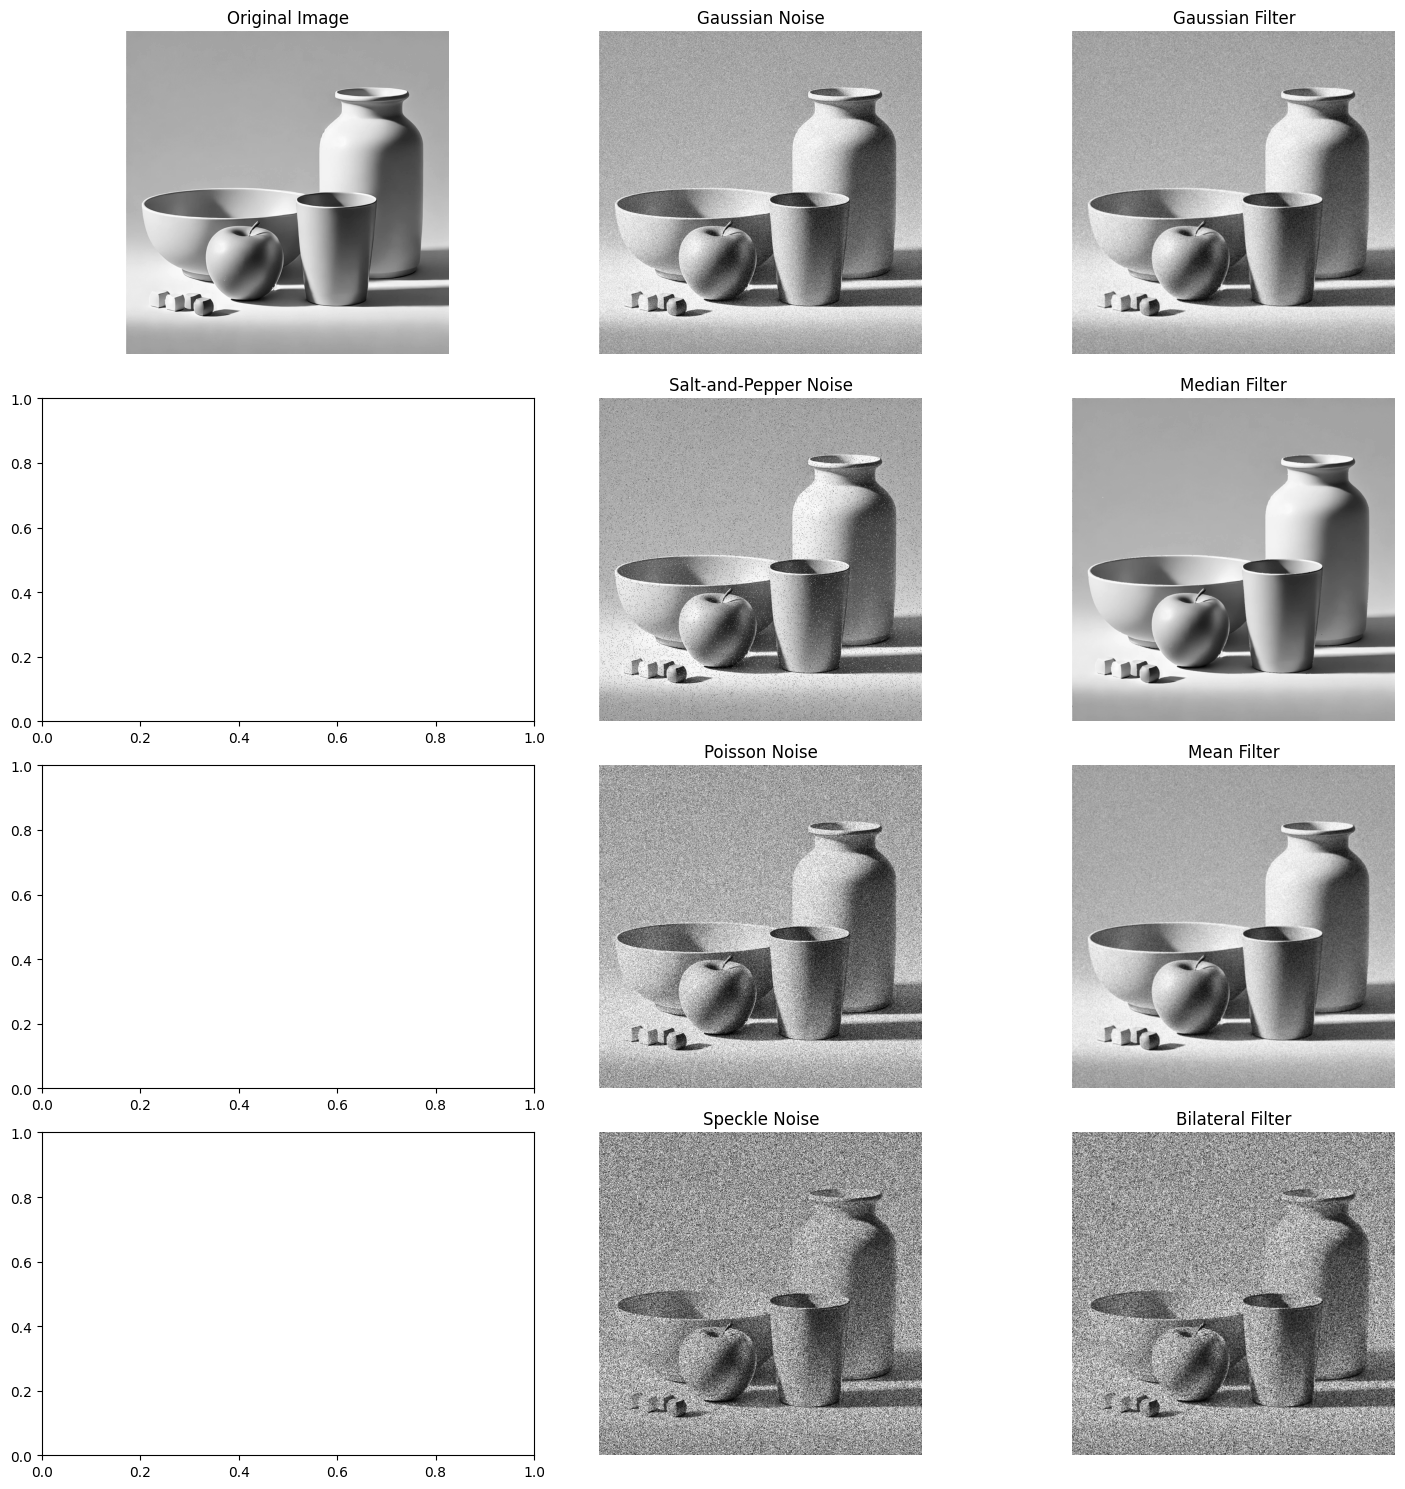

In [254]:
fig, axs = plt.subplots(4, 3, figsize=(15, 15))

# Original Image
axs[0, 0].imshow(image, cmap='gray')
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

# Gaussian Noise
axs[0, 1].imshow(gaussian_noisy, cmap='gray')
axs[0, 1].set_title('Gaussian Noise')
axs[0, 1].axis('off')

# Gaussian Filter
axs[0, 2].imshow(gaussian_filtered, cmap='gray')
axs[0, 2].set_title('Gaussian Filter')
axs[0, 2].axis('off')

# Salt-and-Pepper Noise
axs[1, 1].imshow(salt_pepper_noisy, cmap='gray')
axs[1, 1].set_title('Salt-and-Pepper Noise')
axs[1, 1].axis('off')

# Median Filter
axs[1, 2].imshow(median_filtered, cmap='gray')
axs[1, 2].set_title('Median Filter')
axs[1, 2].axis('off')

# Poisson Noise
axs[2, 1].imshow(poisson_noisy, cmap='gray')
axs[2, 1].set_title('Poisson Noise')
axs[2, 1].axis('off')

# Mean Filter
axs[2, 2].imshow(mean_filtered, cmap='gray')
axs[2, 2].set_title('Mean Filter')
axs[2, 2].axis('off')

# Speckle Noise
axs[3, 1].imshow(speckle_noisy, cmap='gray')
axs[3, 1].set_title('Speckle Noise')
axs[3, 1].axis('off')

# Bilateral Filter
axs[3, 2].imshow(bilateral_filtered, cmap='gray')
axs[3, 2].set_title('Bilateral Filter')
axs[3, 2].axis('off')

plt.tight_layout()
plt.show()

## TLDR <a class="anchor" id="last-bullet"></a>

### **Summary: Affine vs. Non-Affine Transformations (Including Homographies)**

1. **Affine Transformations**:
   - Preserve straight lines, angles, and parallelism.
   - Include operations like **translation**, **rotation**, **scaling**, and **shearing**.
   - Maintain the shape of objects (e.g., a rectangle stays a rectangle).
   - Example: Rotating and resizing an image while keeping lines parallel.

2. **Non-Affine Transformations** (Including Homographies):
   - Do **not** preserve parallelism and proportions along lines.
   - Introduce nonlinear changes, like **perspective distortion** or **warping**.
   - **Homographies** (Perspective transformations) simulate 3D effects on a 2D plane, making parallel lines converge (e.g., how a road narrows into the distance).
   - Example: Skewing a rectangle into a trapezoid as if viewed from an angle.

### Key Difference:
- **Affine** keeps things straight and parallel.
- **Non-affine** allows for perspective changes and more complex distortions, like viewing an object from a different angle.

### **Summary: Linear vs. Non-Linear Image Operations**

**Image operations** can be classified into linear and non-linear based on how they modify pixel values.

### Linear Image Operations:
- **Definition**: The output pixel values are a linear combination of the input pixel values.
- **Examples**:
  1. **Convolution**: Filtering operations like blurring, sharpening, and edge detection.
  2. **Brightness Adjustment**: Adding a constant value to all pixels.
  3. **Contrast Scaling**: Multiplying pixel values by a constant factor.
- **Characteristics**:
  - Preserves straight lines and proportions.
  - Computationally efficient but may blur edges.

### Non-Linear Image Operations:
- **Definition**: The output is not a simple linear combination of the input pixels.
- **Examples**:
  1. **Median Filtering**: Removes noise while preserving edges.
  2. **Morphological Operations**: Erosion, dilation, for structure enhancement.
  3. **Histogram Equalization**: Improves contrast non-linearly.
- **Characteristics**:
  - Better at preserving details and edges.
  - More complex and computationally intensive.

### Conclusion:
- **Linear operations** are faster and simpler but can blur details.
- **Non-linear operations** preserve details and edges better but require more computation.

### **Summary: Image Interpolation**

**Image interpolation** is the process of estimating pixel values when transforming an image (resizing, rotating, or warping) to ensure smooth transitions and preserve quality.

### Key Methods:

1. **Nearest Neighbor**:
   - Fast, but can be blocky or pixelated.
   
2. **Bilinear**:
   - Smooths the image by averaging nearby pixels, but may blur edges.
   
3. **Bicubic**:
   - Uses more pixels for sharper and smoother results, better detail preservation.
   
4. **Lanczos**:
   - Best for detail and sharpness, ideal for downscaling, but computationally expensive.

### Applications:
- **Resizing**: Enlarging or shrinking an image.
- **Rotation**: Estimating pixel values at new angles.
- **Warping**: Handling non-uniform transformations smoothly.

### Conclusion:
The choice of interpolation depends on the trade-off between speed and quality, with **bicubic** and **Lanczos** providing the best balance for high-quality results.

### **Summary: Image Noise and Filters**

We applied different types of noise to an image and used specific filters to reduce them:

---

#### 1. **Gaussian Noise**:
- **Appearance**: Random speckles.
- **Filter**: **Gaussian Filter** – Smooths the noise while maintaining edges.

#### 2. **Salt-and-Pepper Noise**:
- **Appearance**: Black and white dots.
- **Filter**: **Median Filter** – Effectively removes noise and preserves edges.

#### 3. **Poisson Noise**:
- **Appearance**: Grainy texture in dark areas.
- **Filter**: **Mean Filter (Averaging)** – Reduces noise but may blur details.

#### 4. **Speckle Noise**:
- **Appearance**: Grainy, dust-like noise.
- **Filter**: **Bilateral Filter** – Reduces noise while preserving edges and details.

---

### Summary:
Different noise types require specific filters:
- **Gaussian Noise**: Gaussian Filter.
- **Salt-and-Pepper Noise**: Median Filter.
- **Poisson Noise**: Mean Filter.
- **Speckle Noise**: Bilateral Filter.

Proper filter choice ensures noise reduction while retaining image details.

Suggestions:
- https://www.youtube.com/watch?v=QNxJoglVS1Q&ab_channel=HanyFarid%2CProfessoratUCBerkeley
- https://www.youtube.com/@hanyfarid5019/playlists